In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson,skellam
from scipy.optimize import minimize
import pystan

### Key to results data:

- Div = League Division
- Date = Match Date (dd/mm/yy)
- Time = Time of match kick off
- HomeTeam = Home Team
- AwayTeam = Away Team
- FTHG and HG = Full Time Home Team Goals
- FTAG and AG = Full Time Away Team Goals
- FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
- HTHG = Half Time Home Team Goals
- HTAG = Half Time Away Team Goals
- HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

### Match Statistics (where available)
- Attendance = Crowd Attendance
- Referee = Match Referee
- HS = Home Team Shots
- AS = Away Team Shots
- HST = Home Team Shots on Target
- AST = Away Team Shots on Target
- HHW = Home Team Hit Woodwork
- AHW = Away Team Hit Woodwork
- HC = Home Team Corners
- AC = Away Team Corners
- HF = Home Team Fouls Committed
- AF = Away Team Fouls Committed
- HFKC = Home Team Free Kicks Conceded
- AFKC = Away Team Free Kicks Conceded
- HO = Home Team Offsides
- AO = Away Team Offsides
- HY = Home Team Yellow Cards
- AY = Away Team Yellow Cards
- HR = Home Team Red Cards
- AR = Away Team Red Cards
- HBP = Home Team Bookings Points (10 = yellow, 25 = red)
- ABP = Away Team Bookings Points (10 = yellow, 25 = red)

In [2]:
df1 = pd.read_csv('./data/2020_21.csv', usecols=[0, 1] + list(range(3, 24)))
df2 = pd.read_csv('./data/2019_20.csv', usecols=[0, 1] + list(range(3, 24)))
df3 = pd.read_csv('./data/2018_19.csv', usecols=list(range(23)))
df4 = pd.read_csv('./data/2017_18.csv', usecols=list(range(23)))

    
li = [df1, df2, df3, df4]
    
data = pd.concat(li, axis=0, ignore_index=True)

In [3]:
import datetime

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data['time_diff'] = (pd.Timestamp(datetime.datetime.today()) - data['Date']).dt.days

In [5]:
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,time_diff
0,E0,2020-12-09,Fulham,Arsenal,0,3,A,0,1,A,...,6,12,12,2,3,2,2,0,0,245
1,E0,2020-12-09,Crystal Palace,Southampton,1,0,H,1,0,H,...,5,14,11,7,3,2,1,0,0,245
2,E0,2020-12-09,Liverpool,Leeds,4,3,H,3,2,H,...,3,9,6,9,0,1,0,0,0,245
3,E0,2020-12-09,West Ham,Newcastle,0,2,A,0,0,D,...,2,13,7,8,7,2,2,0,0,245
4,E0,2020-09-13,West Brom,Leicester,0,3,A,0,0,D,...,7,12,9,2,5,1,1,0,0,332


## Building a model

In [6]:
X = data[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]

In [7]:
X.iloc[:,[0,1,3]].assign(home=0)

,HomeTeam,AwayTeam,FTAG,home
0,Fulham,Arsenal,3,0
1,Crystal Palace,Southampton,0,0
2,Liverpool,Leeds,3,0
3,West Ham,Newcastle,2,0
4,West Brom,Leicester,3,0
...,...,...,...,...
1515,Newcastle,Chelsea,0,0
1516,Southampton,Man City,1,0
1517,Swansea,Stoke,2,0
1518,Tottenham,Leicester,4,0


In [8]:
#getting an appropriate dataset ready for training...
X = pd.concat([X.iloc[:,[0,1,2]].assign(home=1).rename(columns={'HomeTeam':'team',
                                                                'AwayTeam':'opponent',
                                                                'FTHG':'goals'}),
               X.iloc[:,[0,1,3]].assign(home=0).rename(columns={'HomeTeam':'team',
                                                                'AwayTeam':'opponent',
                                                                'FTAG':'goals'})])

In [9]:
model = smf.glm(formula='goals ~ home + team + opponent', 
                data=X, family = sm.families.Poisson()).fit()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 3040
Model:                            GLM   Df Residuals:                     2986
Model Family:                 Poisson   Df Model:                           53
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4585.6
Date:                Wed, 11 Aug 2021   Deviance:                       3831.8
Time:                        13:04:42   Pearson chi2:                 3.37e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.3666      0.098      3.753      0.000       0.175       0.558
team[T.Aston Villa]             -0.0919      0.116     -0.790      0.430      -0.320       0.136
team[T.Bournemouth]             -0.0810      0.102     -0.794      0.427      -0.281       0.119
team[T.Brighton]                -0.2464      0.098     -2.516      0.012      -0.438      -0.054
team[T.Burnley]                 -0.2973      0.099     -2.988      0.003      -0.492      -0.102
team[T.Cardiff]                 -0.0134      0.146     -0.092      0.927      -0.299       0.272
team[T.Chelsea]                 -0.2069      0.097     -2.127      0.033      -0.397      -0.016
team[T.Crystal Palace]          -0.2492      0.098     -2.536      0.011      -0.442      -0.057
team[T.Everton]                 -0.1831      0.096     -1.899      0.058      -0.372       0.006
team[T.Fulham]                  -0.2249      0.122     -1.850      0.064      -0.463       0.013
team[T.Huddersfield]            -0.3739      0.128     -2.914      0.004      -0.625      -0.122
team[T.Leeds]                   -0.1765      0.157     -1.123      0.261      -0.485       0.132
team[T.Leicester]               -0.1296      0.095     -1.360      0.174      -0.316       0.057
team[T.Liverpool]                0.0036      0.092      0.039      0.969      -0.177       0.184
team[T.Man City]                 0.1505      0.089      1.694      0.090      -0.024       0.325
team[T.Man United]              -0.0399      0.093     -0.429      0.668      -0.222       0.142
team[T.Newcastle]               -0.2419      0.098     -2.470      0.014      -0.434      -0.050
team[T.Norwich]                 -0.0568      0.149     -0.382      0.703      -0.348       0.235
team[T.Sheffield United]        -0.4271      0.131     -3.267      0.001      -0.683      -0.171
team[T.Southampton]             -0.1100      0.095     -1.162      0.245      -0.296       0.076
team[T.Stoke]                   -0.1757      0.156     -1.127      0.260      -0.481       0.130
team[T.Swansea]                 -0.3846      0.169     -2.270      0.023      -0.717      -0.053
team[T.Tottenham]               -0.0991      0.094     -1.049      0.294      -0.284       0.086
team[T.Watford]                 -0.0988      0.102     -0.966      0.334      -0.299       0.102
team[T.West Brom]               -0.1400      0.118     -1.188      0.235      -0.371       0.091
team[T.West Ham]                -0.0459      0.093     -0.493      0.622      -0.228       0.137
team[T.Wolves]                  -0.2392      0.107     -2.246      0.025      -0.448      -0.030
opponent[T.Aston Villa]         -0.0440      0.121     -0.363      0.717      -0.282       0.194
opponent[T.Bournemouth]          0.0922      0.103      0.898      0.369    

In [11]:
model.predict(pd.DataFrame(data={'team' : 'Liverpool', 'opponent' : 'Norwich', 'home' : 1},
                           index=[1]))

1    1.480695
dtype: float64

In [12]:
model.predict(pd.DataFrame(data={'team' : 'Norwich', 'opponent' : 'Liverpool', 'home' : 0},
                           index=[1]))

1    1.454441
dtype: float64

In [13]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    
    
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [14]:
home_team = 'Liverpool'
away_team = 'Burnley'
max_goals = 5

score_probs = simulate_match(model, homeTeam=home_team, awayTeam=away_team, max_goals=max_goals)

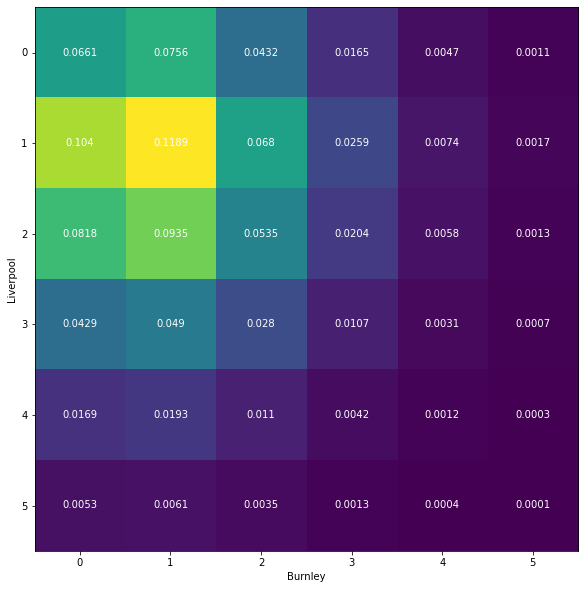

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(score_probs)
plt.xlabel(away_team)
plt.ylabel(home_team)

for i in range(max_goals+1):
    for j in range(max_goals+1):
        text = ax.text(j, i, np.around(score_probs[i, j], decimals=4),
                       ha="center", va="center", color="w")

plt.show()

In [16]:
#Seems to be predicting 1-1 for most of the games.

In [17]:
def rho_correction(x, y, lambda_x, mu_y, rho):
    if x==0 and y==0:
        return 1- (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0

In [18]:
def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
            np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

In [19]:
def solve_parameters(dataset, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("Something's not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0, 1.0]) # rho (score correction), gamma (home advantage)
                                     ))
    def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like(row.FTHG, row.FTAG, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                     score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], rho, gamma) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints, **kwargs)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x))

In [20]:
params = solve_parameters(data)

<ipython-input-19-a541f3662098>:18: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))
<ipython-input-19-a541f3662098>:17: RuntimeWarning: invalid value encountered in log
  return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) +


Optimization terminated successfully    (Exit mode 0)
            Current function value: 4336.532707593134
            Iterations: 70
            Function evaluations: 4117
            Gradient evaluations: 70


In [21]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_'+homeTeam] + param_dict['defence_'+awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_'+homeTeam] + param_dict['attack_'+awayTeam])]

def dixon_coles_simulate_match(params_dict, homeTeam, awayTeam, max_goals=5):
    team_avgs = calc_means(params_dict, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array([[rho_correction(home_goals, away_goals, team_avgs[0],
                                                   team_avgs[1], params['rho']) for away_goals in range(2)]
                                   for home_goals in range(2)])
    output_matrix[:2,:2] = output_matrix[:2,:2] * correction_matrix
    return output_matrix

In [22]:
home_team = 'Man City'
away_team = 'Arsenal'
max_goals = 5

score_probs = dixon_coles_simulate_match(params, home_team, away_team, max_goals=max_goals)

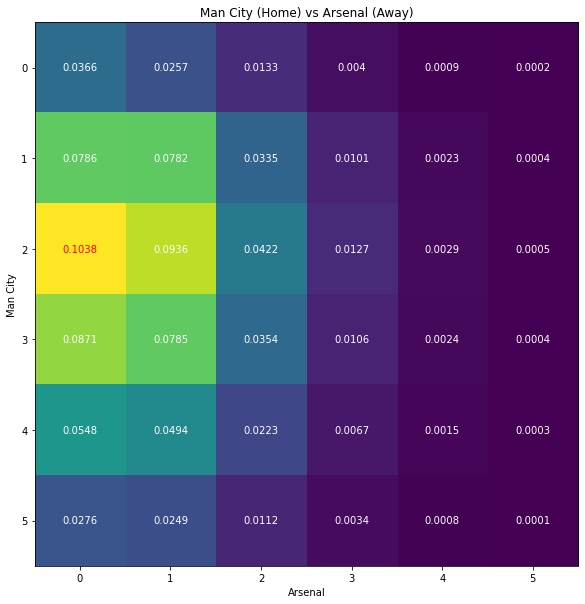

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(score_probs)
plt.xlabel(away_team)
plt.ylabel(home_team)
plt.title(f'{home_team} (Home) vs {away_team} (Away)')

for i in range(max_goals+1):
    for j in range(max_goals+1):
        if score_probs[i, j] == np.max(score_probs):
            text = ax.text(j, i, np.around(score_probs[i, j], decimals=4),
                           ha="center", va="center", color="r")
        else:
            text = ax.text(j, i, np.around(score_probs[i, j], decimals=4),
                           ha="center", va="center", color="w")

plt.show()

In [24]:
def solve_parameters_decay(dataset, xi=0.001, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("something not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0,1.0]) # rho (score correction), gamma (home advantage)
                                     ))
        
    def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi=xi):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                                  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like_decay(row.FTHG, row.FTAG, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                                      score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], 
                                      rho, gamma, row.time_diff, xi=xi) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x))

In [25]:
params_2 = solve_parameters_decay(data, xi=0.00325)

<ipython-input-24-61056e9edd7d>:19: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))
<ipython-input-24-61056e9edd7d>:18: RuntimeWarning: invalid value encountered in log
  return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) +


Optimization terminated successfully    (Exit mode 0)
            Current function value: 875.4272962325622
            Iterations: 66
            Function evaluations: 3851
            Gradient evaluations: 66


In [26]:
params_2

{'attack_Arsenal': 1.2989048644716479,
 'attack_Aston Villa': 1.0575265633013715,
 'attack_Bournemouth': 1.026801830711719,
 'attack_Brighton': 0.8173325149956401,
 'attack_Burnley': 0.8470556683998886,
 'attack_Cardiff': 0.7918241023414495,
 'attack_Chelsea': 1.291386269921952,
 'attack_Crystal Palace': 0.8846925740716014,
 'attack_Everton': 0.9795013279642164,
 'attack_Fulham': 0.4667339610875318,
 'attack_Huddersfield': 0.3589432244431294,
 'attack_Leeds': 1.392090305811654,
 'attack_Leicester': 1.3861683330336907,
 'attack_Liverpool': 1.4536645460638247,
 'attack_Man City': 1.7623773557515126,
 'attack_Man United': 1.503567571764447,
 'attack_Newcastle': 1.0471997743442423,
 'attack_Norwich': 0.16116995710145923,
 'attack_Sheffield United': 0.3934618310403475,
 'attack_Southampton': 1.0795974233786783,
 'attack_Stoke': 0.6613201852433421,
 'attack_Swansea': 0.47070277633128355,
 'attack_Tottenham': 1.3875542858029466,
 'attack_Watford': 0.9868785290039588,
 'attack_West Brom': 0.91

In [27]:
home_team = 'Liverpool'
away_team = 'Norwich'
max_goals = 5

score_probs = dixon_coles_simulate_match(params_2, homeTeam=home_team, awayTeam=away_team, max_goals=max_goals)

In [31]:
def plot_score_probs(score_probs):

    fig, ax = plt.subplots(figsize=(10,10))

    ax.imshow(score_probs)
    plt.xlabel(away_team)
    plt.ylabel(home_team)
    plt.title(f'{home_team} (Home) vs {away_team} (Away)')

    for i in range(max_goals+1):
        for j in range(max_goals+1):
            if score_probs[i, j] == np.max(score_probs):
                text = ax.text(j, i, np.around(score_probs[i, j], decimals=4),
                               ha="center", va="center", color="r")
            else:
                text = ax.text(j, i, np.around(score_probs[i, j], decimals=4),
                               ha="center", va="center", color="w")

    plt.show()

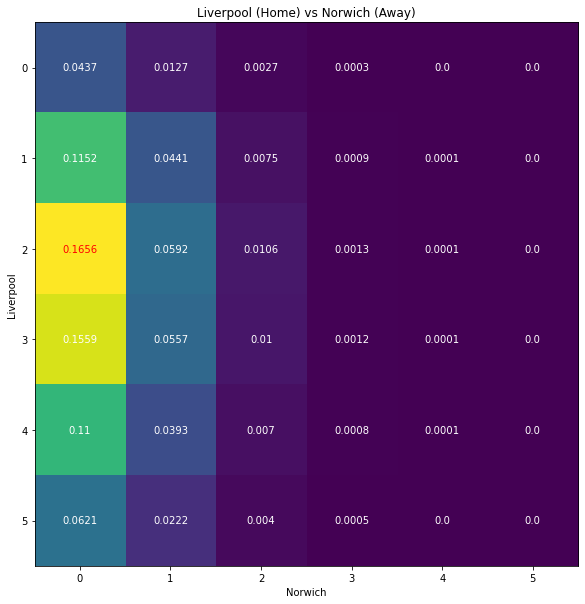

In [32]:
plot_score_probs(score_probs)

In [30]:
np.unravel_index(score_probs.argmax(), score_probs.shape)

(2, 0)

In [ ]:
np.sum(np.array([1,2,3]) * np.array([1,2,3]))

In [ ]:
def points_func(m, element_type):
    #(score, assist, nothing)
    
    if element_type == 'DEF': return np.sum(m * np.array([6, 3, 0]))
    if element_type == 'MID': return np.sum(m * np.array([5, 3, 0]))
    if element_type == 'FWD': return np.sum(m * np.array([4, 3, 0]))
    
def prob_score(T, theta):
    
    return T * theta / 90

def prob_assist(T, theta):
    
    return T * theta / 90

def prob_nothing(T, theta):
    
    return (T * (theta - 1) + 90) / 90

In [ ]:
np.random.multinomial()